


# Weight Decay

Now that we have characterized the problem of overfitting
and motivated the need for capacity control,
we can begin discussing some of the popular techniques
used to these ends in practice.
Recall that we can always mitigate overfitting
by going out and collecting more training data,
that can be costly and time consuming,
typically making it impossible in the short run.
For now, let's assume that we have already obtained
as much high-quality data as our resources permit
and focus on techniques aimed at limiting the capacity
of the function classes under consideration.

In our toy example,
we saw that we could control the complexity of a polynomial
by adjusting its degree.
However, most of machine learning
does not consist of polynomial curve fitting.
And moreover, even when we focus on polynomial regression,
when we deal with high-dimensional data,
manipulating model capacity by tweaking the degree $d$ is problematic.
To see why, note that for multivariate data
we must generalize the concept of polynomials
to include *monomials*, which are simply
products of powers of variables.
For example, $x_1^2 x_2$, and $x_3 x_5^2$ are both monomials of degree $3$.
The number of such terms with a given degree $d$
blows up as a function of the degree $d$.

Concretely, for vectors of dimensionality $D$,
the number of monomials of a given degree $d$ is ${D -1 + d} \choose {D-1}$.
Hence, a small change in degree, even from say $1$ to $2$ or $2$ to $3$
would entail a massive blowup in the complexity of our model.
Thus, tweaking the degree is too blunt a hammer.
Instead, we need a more fine-grained tool
for adjusting function complexity.

## Squared Norm Regularization

*Weight decay* (commonly called *L2* regularization),
might be the most widely-used technique
for regularizing parametric machine learning models.
The basic intuition behind weight decay is
the notion that among all functions $f$,
the function $f = 0$ is the simplest.
Intuitively, we can then measure functions by their proximity to zero.
But how precisely should we measure
the distance between a function and zero?
There is no single right answer.
In fact, entire branches of mathematics,
e.g. in functional analysis and the theory of Banach spaces
are devoted to answering this issue.

For our present purposes, a very simple interpretation will suffice:
We will consider a linear function
$f(\mathbf{x}) = \mathbf{w}^\top \mathbf{x}$
to be simple if its weight vector is small.
We can measure this via $||\mathbf{w}||^2$.
One way of keeping the weight vector small
is to add its norm as a penalty term
to the problem of minimizing the loss.
Thus we replace our original objective,
*minimize the prediction error on the training labels*,
with new objective,
*minimize the sum of the prediction error and the penalty term*.
Now, if the weight vector becomes too large,
our learning algorithm will find more profit in
minimizing the norm $|| \mathbf{w} ||^2$
versus minimizing the training error.
That's exactly what we want.
To illustrate things in code, let's revive our previous example
from linear regression.
There, our loss was given by

$$l(\mathbf{w}, b) = \frac{1}{n}\sum_{i=1}^n \frac{1}{2}\left(\mathbf{w}^\top \mathbf{x}^{(i)} + b - y^{(i)}\right)^2.$$

Recall that $\mathbf{x}^{(i)}$ are the observations,
$y^{(i)}$ are labels, and $(\mathbf{w}, b)$
are the weight and bias parameters respectively.
To arrive at a new loss function
that penalizes the size of the weight vector,
we need to add $||\mathbf{w}||^2$, but how much should we add?
To address this, we need to add a new hyperparameter,
that we will call the *regularization constant* and denote by $\lambda$:

$$l(\mathbf{w}, b) + \frac{\lambda}{2} \|\boldsymbol{w}\|^2$$

This non-negative parameter $\lambda \geq 0$
governs the amount of regularization.
For $\lambda = 0$, we recover our original loss function,
whereas for $\lambda > 0$ we ensure that $\mathbf{w}$ cannot grow too large. The astute reader might wonder why we are squaring
the norm of the weight vector.
We do this for two reasons.
First, we do it for computational convenience.
By squaring the L2 norm, we remove the square root,
leaving the sum of squares of each component of the weight vector.
This is convenient because it is easy to compute derivatives of a sum of terms (the sum of derivatives equals the derivative of the sum).

Moreover, you might ask, why the L2 norm in the first place and not the L1 norm, or some other distance function.
In fact, several other choices are valid
and are popular throughout statistics.
While L2-regularized linear models constitute
the classic *ridge regression* algorithm
L1-regularizaed linear regression
is a similarly fundamental model in statistics
popularly known as *lasso regression*.

One mathematical reason for working with the L2 norm and not some other norm,
is that it penalizes large components of the weight vector
much more than it penalizes small ones.
This encourages our learning algorithm to discover models
which distribute their weight across a larger number of features,
which might make them more robust in practice
since they do not depend precariously on a single feature.
The stochastic gradient descent updates for L2-regularied regression
are as follows:

$$
\begin{aligned}
w & \leftarrow \left(1- \frac{\eta\lambda}{|\mathcal{B}|} \right) \mathbf{w} - \frac{\eta}{|\mathcal{B}|} \sum_{i \in \mathcal{B}} \mathbf{x}^{(i)} \left(\mathbf{w}^\top \mathbf{x}^{(i)} + b - y^{(i)}\right),
\end{aligned}
$$

As before, we update $\mathbf{w}$ based on the amount
by which our estimate differs from the observation.
However, we also shrink the size of $\mathbf{w}$ towards $0$.
That's why the method is sometimes called "weight decay":
because the penalty term literally causes our optimization algorthm
to *decay* the magnitude of the weight at each step of training.
This is more convenient than having to pick
the number of parameters as we did for polynomials.
In particular, we now have a continuous mechanism
for adjusting the complexity of $f$.
Small values of $\lambda$ correspond to unconstrained $\mathbf{w}$,
whereas large values of $\lambda$ constrain $\mathbf{w}$ considerably.
Since we don't want to have large bias terms either,
we often add $b^2$ as a penalty, too.

## High-dimensional Linear Regression

For high-dimensional regression it is difficult
to pick the 'right' dimensions to omit.
Weight-decay regularization is a much more convenient alternative.
We will illustrate this below.
First, we will generate some synthetic data as before

$$y = 0.05 + \sum_{i = 1}^d 0.01 x_i + \epsilon \text{ where }
\epsilon \sim \mathcal{N}(0, 0.01)$$

representing our label as a linear function of our inputs,
corrupted by Gaussian noise with zero mean and variance 0.01.
To observe the effects of overfitting more easily,
we can make our problem high-dimensional,
setting the data dimension to $d = 200$
and working with a relatively small number of training examples—here we'll set the sample size to 20:

In [ ]:
import torch
import sys
from IPython import display
sys.path.insert(0, '..')

import torch.nn as nn
from torch.utils import data
%config InlineBackend.figure_formats = ['svg']
import matplotlib.pyplot as plt

n_train, n_test, num_inputs, batch_size = 20, 100, 200, 5
true_w, true_b = torch.ones((num_inputs, 1)) * 0.01, 0.05

def synthetic_data(w, b, num_examples): 
    """Generate y = X w + b + noise."""
    X = torch.zeros(size=(num_examples, len(w))).normal_()
    y = torch.matmul(X, w) + b
    y += torch.zeros(size=y.shape).normal_(std=0.01)
    return X, y

def load_array(data_arrays, batch_size, is_train=True):  
    """Construct a PyTorch data loader"""
    dataset = data.TensorDataset(*data_arrays)
    return data.DataLoader(dataset, batch_size, shuffle=is_train)

train_data = synthetic_data(true_w, true_b, n_train)
train_iter = load_array(train_data, batch_size)
test_data = synthetic_data(true_w, true_b, n_test)
test_iter = load_array(test_data, batch_size, is_train=False)

## Implementation from Scratch

Next, we will show how to implement weight decay from scratch.
All we have to do here is to add the squared $\ell_2$ penalty
as an additional loss term added to the original target function.
The squared norm penalty derives its name from the fact
that we are adding the second power $\sum_i w_i^2$.
The $\ell_2$ is just one among an infinite class of norms call p-norms,
many of which you might encounter in the future.
In general, for some number $p$, the $\ell_p$ norm is defined as

$$\|\mathbf{w}\|_p^p := \sum_{i=1}^d |w_i|^p$$

### Initialize Model Parameters

First, we'll define a function to randomly initialize our model parameters and set `requires_grad`as `True` on each to allocate memory for the gradients we will calculate.

In [ ]:
def init_params():
    w = torch.normal(0, 1, size=(num_inputs, 1), requires_grad=True)
    b = torch.zeros(1, requires_grad=True)
    return [w, b]

### Define $\ell_2$ Norm Penalty

Perhaps the most convenient way to implement this penalty
is to square all terms in place and summ them up.
We divide by $2$ by convention
(when we take the derivative of a quadratic function,
the $2$ and $1/2$ cancel out, ensuring that the expression
for the update looks nice and simple).

In [ ]:
def l2_penalty(w):
    return torch.sum(w.pow(2)) / 2

### Define Training and Testing

The following code defines how to train and test the model
separately on the training data set and the test data set.
Unlike the previous sections, here, the $\ell_2$ norm penalty term
is added when calculating the final loss function.
The linear network and the squared loss
haven't changed since the previous chapter,
so we'll just import them via `linreg` and `squared_loss`
to reduce clutter.

In [ ]:
## A set of helper functions and classes 
def linreg(X, w, b):
     return torch.matmul(X, w) + b

def squared_loss(y_hat, y):
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2

def sgd(params, lr, batch_size):
    for param in params:
        param.data += -lr * param.grad.data / batch_size

def evaluate_loss(net, data_iter, loss):  
    """Evaluate the loss of a model on the given dataset."""
    metric = Accumulator(2)  # sum_loss, num_examples
    for X, y in data_iter:
        l = loss(net(X), y.reshape(-1, 1))
        if l.nelement() != 1:
            metric.add(l.sum(), y.numpy().size)
        else:
            metric.add(l*len(y), y.numpy().size)
    return metric[0] / metric[1]

def semilogy(x_vals, y_vals, x_label, y_label, x2_vals=None, y2_vals=None, legend=None, figsize=(3.5, 2.5)):    
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.semilogy(x_vals, y_vals)
    if x2_vals and y2_vals:
        plt.semilogy(x2_vals, y2_vals, linestyle=':')
        plt.legend(legend)
        
class Animator: 
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear', fmts=None,
                 nrows=1, ncols=1, figsize=(3.5, 2.5)):
        """Incrementally plot multiple lines."""
        if legend is None:
            legend = []
        
        self.fig, self.axes = plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes, ]
        # Use a lambda to capture arguments
        self.config_axes = lambda: self.set_axes(
            self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def set_axes(self, axes, xlabel, ylabel, xlim, ylim, xscale, yscale, legend):  
        """Set the axes for matplotlib."""
        axes.set_xlabel(xlabel)
        axes.set_ylabel(ylabel)
        axes.set_xscale(xscale)
        axes.set_yscale(yscale)
        axes.set_xlim(xlim)
        axes.set_ylim(ylim)
        if legend:
            axes.legend(legend)
        axes.grid()

    def add(self, x, y):
        """Add multiple data points into the figure."""
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        if not self.fmts:
            self.fmts = ['-'] * n
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)

class Accumulator:  
    """Sum a list of numbers over time."""
    def __init__(self, n):
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a+float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [ ]:
def train(lambd):
    w, b = init_params()
    net, loss = lambda X: linreg(X, w, b), squared_loss
    num_epochs, lr = 100, 0.003
    animator = Animator(xlabel='epochs', ylabel='loss', yscale='log',
                            xlim=[1, num_epochs], legend=['train', 'test'])
    for epoch in range(1, num_epochs + 1):
        for X, y in train_iter:
            with torch.enable_grad():
                # The L2 norm penalty term has been added, and broadcasting
                # makes l2_penalty(w) a vector whose length is batch_size
                l = loss(net(X), y) + lambd * l2_penalty(w)
            l.sum().backward()
            sgd([w, b], lr, batch_size)
        if epoch % 5 == 0:
            animator.add(epoch, (evaluate_loss(net, train_iter, loss),
                                 evaluate_loss(net, test_iter, loss)))
    print('l1 norm of w:', torch.norm(w).item())

### Training without Regularization

Next, let's train and test the high-dimensional linear regression model.
When `lambd = 0` we do not use weight decay.
As a result, while the training error decreases, the test error does not.
This is a perfect example of overfitting.

l1 norm of w: 32.027957916259766


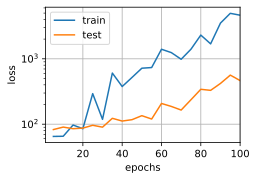

In [ ]:
train(lambd=0)


### Using Weight Decay

The example below shows that even though the training error increased,
the error on the test set decreased.
This is precisely the improvement that we expect from using weight decay.
While not perfect, overfitting has been mitigated to some extent.
In addition, the $\ell_2$ norm of the weight $\mathbf{w}$
is smaller than without using weight decay.

l1 norm of w: 37.99309158325195


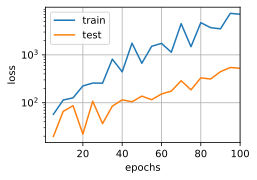

In [ ]:
train(lambd=3)

## Concise Implementation

Because weight decay is ubiquitous in neural network optimization,
Pytorch makes it especially convenient,
integrating weight decay into the optimization algorithm itself
for easy use in combination with any loss function.
Moreover, this integration serves a computational benefit,
allowing implementation tricks to add weight decay to the algorithm,
without any additional computational overhead.
Since the weight decay portion of the update
depdends only on the current value of each parameter,
and the optimizer must to touch each parameter once anyway.

In the following code, we specify
the weight decay hyper-parameter directly
through the `weight_decay` parameter when instantiating our `Optimizer`.
By default, Pytorch decays both weights and biases simultaneously.
Per-Parameter or Parameters with different lr,weight_decay can be specified 
in the optimizer function using an iterable of `dict`s

In [ ]:
def fit_and_plot_pytorch(wd):
    net = nn.Sequential(nn.Linear(200, 1))
    #Random Uniform Initialization of the Model parameters
    for param in net.parameters():
        param.data.uniform_()
    
    loss = nn.MSELoss()
    # The weight parameter has been decayed with its weight_decay set as wd
    # The weight_decay for bias is by default zero (no decay)
    optimizer = torch.optim.SGD([
        {"params":net[0].weight,'weight_decay': wd},
        {"params":net[0].bias}
    ],lr=lr)
    train_ls, test_ls = [], []
    for _ in range(num_epochs):
        for X, y in train_iter:
            with torch.enable_grad():
                optimizer.zero_grad()
                l = loss(net(X), y)
            l.backward()
            # Call the step function to
            # update the weight and bias
            optimizer.step()
        train_ls.append(torch.mean(loss(net(train_features),
                             train_labels)).item())
        test_ls.append(torch.mean(loss(net(test_features),
                            test_labels)).item())
    semilogy(range(1, num_epochs + 1), train_ls, 'epochs', 'loss',
                 range(1, num_epochs + 1), test_ls, ['train', 'test'])
    print('L2 norm of w:', net[0].weight.norm().item())

The plots look just the same as when we implemented weight decay from scratch
but they run a bit faster and are easier to implement,
a benefit that will become more pronounced for large problems.

In [ ]:
fit_and_plot_pytorch(0)

NameError: ignored

In [ ]:
fit_and_plot_pytorch(3)

So far, we only touched upon one notion of
what constitutes a simple *linear* function.
For nonlinear functions, what constitutes *simplicity*
can be a far more complex question.
For instance, there exist [Reproducing Kernel Hilbert Spaces (RKHS)](https://en.wikipedia.org/wiki/Reproducing_kernel_Hilbert_space)
which allow one to use many of the tools
introduced for linear functions in a nonlinear context.
Unfortunately, RKHS-based algorithms
do not always scale well to massive amounts of data.
For the purposes of this book, we limit ourselves
to simply summing over the weights for different layers,
e.g. via $\sum_l \|\mathbf{w}_l\|^2$,
which is equivalent to weight decay applied to all layers.


## Summary

* Regularization is a common method for dealing with overfitting. It adds a penalty term to the loss function on the training set to reduce the complexity of the learned model.
* One particular choice for keeping the model simple is weight decay using an $\ell_2$ penalty. This leads to weight decay in the update steps of the learning algorithm.
* Pytorch provides automatic weight decay functionality in the optimizer by setting the hyperparameter `weight_decay`.
* You can have different lr,Weight_decay for different sets of parameters in an optimizer. They need to be passed as dicts.

# Dropout

Just now, we introduced the classical approach
of regularizing statistical models by penalyzing
the $\ell_2$ norm of the weights.
In probabilistic terms, we could justify this technique
by arguing that we have assumed a prior belief
that weights take values from a Gaussian distribution with mean $0$.
More intuitively, we might argue
that we encouraged the model to spread out its weights
among many features and rather than depending too much
on a small number of potentially spurious associations.

## Overfitting Revisited

Given many more features than examples, linear models can overfit.
But when there are many more examples than features,
we can generally count on linear models not to overfit.
Unfortunately, the reliability with which linear models generalize
comes at a cost:
Linear models can’t take into account interactions among features.
For every feature, a linear model must assign
either a positive or a negative weight.
They lack the flexibility to account for context.

In more formal texts, you’ll see this fundamental tension
between generalizability and flexibility
discussed as the *bias-variance tradeoff*.
Linear models have high bias
(they can only represent a small class of functions),
but low variance (they give similar results
across different random samples of the data).

Deep neural networks take us to the opposite end
of the bias-variance spectrum.
Neural networks are so flexible because
they aren’t confined to looking at each feature individually.
Instead, they can learn interactions among groups of features.
For example, they might infer that “Nigeria” and “Western Union”
appearing together in an email indicates spam
but that “Nigeria” without “Western Union” does not.

Even when we only have a small number of features,
deep neural networks are capable of overfitting.
In 2017, a group of researchers presented a now well-known
demonstration of the incredible flexibility of neural networks.
They presented a neural network with randomly-labeled images
(there was no true pattern linking the inputs to the outputs)
and found that the neural network, optimized by SGD,
could label every image in the training set perfectly.

Consider what this means.
If the labels are assigned uniformly at random and there are 10 classes,
then no classifier can get better than 10% accuracy on holdout data.
Yet even in these situations, when there is no true pattern to be learned, neural networks can perfectly fit the training labels.

## Robustness through Perturbations

Let's think briefly about what we expect from a good statistical model.
We want it to do well on unseen test data.
One way we can accomplish this is by asking
what constitutes a a 'simple' model?
Simplicity can come in the form
of a small number of dimensions,
which is what we did when discussing fitting a model
with monomial basis functions.
Simplicity can also come in the form
of a small norm for the basis functions.
This led us to weight decay ($\ell_2$ regularization).
Yet a third notion of simplicity that we can impose
is that the function should be robust
under small changes in the input.
For instance, when we classify images,
we would expect that adding some random noise
to the pixels should be mostly harmless.


In 1995, Christopher Bishop formalized
a form of this idea when he proved
that [*training with input noise is equivalent to Tikhonov regularization*](https://www.mitpressjournals.org/doi/10.1162/neco.1995.7.1.108).
In other words, he drew a clear mathematical connection
between the requirement that a function be smooth (and thus simple),
as we discussed in the section on weight decay,
with and the requirement that it be resilient to perturbations in the input.

Then in 2014, [Srivastava et al., 2014](http://jmlr.org/papers/volume15/srivastava14a.old/srivastava14a.pdf),
developed a clever idea for how to apply Bishop's idea
to the *internal* layers of the network, too.
Namely they proposed to inject noise into each layer of the network
before calculating the subsequent layer during training.
They realized that when training deep network with many layers,
enforcing smoothness just on the input-output mapping
misses out on what is happening internally in the network.
Their proposed idea is called *dropout*,
and it is now a standard technique
that is widely used for training neural networks.
Throughout training, on each iteration,
dropout regularization consists simply of zeroing out
some fraction (typically 50%) of the nodes in each layer
before calculating the subsequent layer.

The key challenge then is how to inject this noise
without introducing undue statistical *bias*.
In other words, we want to perturb the inputs
to each layer during training
in such a way that the expected value of the layer
is equal to the value it would have taken
had we not introduced any noise at all.

In Bishop's case, when we are adding
Gaussian noise to a linear model,
this is simple:
At each training iteration, just add noise
sampled from a distribution with mean zero
$\epsilon \sim \mathcal{N}(0,\sigma^2)$ to the input $\mathbf{x}$ ,
yielding a perturbed point $\mathbf{x}' = \mathbf{x} + \epsilon$.
In expectation, $\mathbf{E}[\mathbf{x}'] = \mathbf{x}$.

In the case of dropout regularization,
one can debias each layer
by normalizing by the fraction of nodes that were not dropped out.
In other words, dropout with drop probability $p$ is applied as follows:

$$
\begin{aligned}
h' =
\begin{cases}
    0 & \text{ with probability } p \\
    \frac{h}{1-p} & \text{ otherwise}
\end{cases}
\end{aligned}
$$

By design, the expectation remains unchanged,
i.e., $\mathbf{E}[h'] = h$.
Intermediate activations $h$ are replaced by a random variable $h'$
with matching expectation.
The name 'dropout' arises from the notion
that some neurons 'drop out' of the computation
for the purpose of computing the final result.
During training, we replace intermediate activations with random variables.

## Dropout in Practice

Recall the multilayer perceptron (:numref:`chapter_mlp`) with a hidden layer and 5 hidden units. Its architecture is given by

$$
\begin{aligned}
    h & = \sigma(W_1 x + b_1) \\
    o & = W_2 h + b_2 \\
    \hat{y} & = \mathrm{softmax}(o)
\end{aligned}
$$

When we apply dropout to the hidden layer,
we are essentially removing each hidden unit with probability $p$,
(i.e., setting their output to $0$).
We can view the result as a network containing
only a subset of the original neurons.
In the image below, $h_2$ and $h_5$ are removed.
Consequently, the calculation of $y$ no longer depends on $h_2$ and $h_5$
and their respective gradient also vanishes when performing backprop.
In this way, the calculation of the output layer
cannot be overly dependent on any one element of $h_1, \ldots, h_5$.
Intuitively, deep learning researchers often explain the inutition thusly:
we do not want the network's output to depend
too precariously on the exact activation pathway through the network.
The original authors of the dropout technique
described their intuition as an effort
to prevent the *co-adaptation* of feature detectors.


In [ ]:
from IPython.display import SVG
SVG(filename = '../img/dropout2.svg')

At test time, we typically do not use dropout.
However, we note that there are some exceptions:
some researchers use dropout at test time as a heuristic appraoch
for estimating the *confidence* of neural network predictions:
if the predictions agree across many different dropout masks,
then we might say that the network is more confident.
For now we will put off the advanced topic of uncertainty estimation
for subsequent chapters and volumes.


## Implementation from Scratch

To implement the dropout function for a single layer,
we must draw as many samples from a Bernoulli (binary) random variable
as our layer has dimensions, where the random variable takes value $1$ (keep) with probability $1-p$ and $0$ (drop) with probability $p$.
One easy way to implement this is to first draw samples
from the uniform distribution $U[0,1]$.
then we can keep those nodes for which the corresponding
sample is greater than $p$, dropping the rest.

In the following code, we implement a `dropout` function
that drops out the elements in the Tensor input `X`
with probability `drop_prob`,
rescaling the remainder as described above
(dividing the survivors by `1.0-drop_prob`).


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import transforms
from torch.utils import data
%config InlineBackend.figure_formats = ['svg']
import matplotlib.pyplot as plt
import sys
from IPython import display
sys.path.insert(0, '..')

In [ ]:
def dropout(X, drop_prob):
    assert 0 <= drop_prob <= 1
    # In this case, all elements are dropped out
    if drop_prob == 1:
        return torch.zeros_like(X)
    mask = (torch.FloatTensor(X.shape).uniform_(0, 1) > drop_prob).float()
    return mask * X / (1.0 - drop_prob)

We can test out the `dropout` function on a few examples.
In the following lines of code, we pass our input `X`
through the dropout operation, with probabilities 0, 0.5, and 1, respectively.

In [ ]:
X = torch.arange(16, dtype = torch.float32).reshape((2, 8))
print(X)
print(dropout(X, 0.))
print(dropout(X, 0.5))
print(dropout(X, 1.))

### Defining Model Parameters

Again, we can use the Fashion-MNIST dataset,
introduced in :numref:`chapter_softmax_scratch`.
We will define a multilayer perceptron with two hidden layers.
The two hidden layers both have 256 outputs.


### Define the Model

The model defined below concatenates the fully-connected layer
 and the activation function ReLU,
 using dropout for the output of each activation function.
 We can set the dropout probability of each layer separately.
 It is generally recommended to set
 a lower dropout probability closer to the input layer.
 Below we set it to 0.2 and 0.5 for the first and second hidden layer respectively.
 By using the `is_training` function described in :numref:`chapter_autograd`,
 we can ensure that dropout is only active during training.

In [ ]:
drop_prob1, drop_prob2 = 0.2, 0.5

class Net(nn.Module):
    def __init__(self, num_inputs = 784, num_outputs = 10, num_hiddens1 = 256, num_hiddens2 = 256, is_training = True):
        super(Net, self).__init__()
        
        self.num_inputs = num_inputs
        self.num_outputs = num_outputs
        self.num_hiddens1 = num_hiddens1
        self.num_hiddens2 = num_hiddens2
        self.is_training = is_training
        
        self.linear_1 = nn.Linear(num_inputs, num_hiddens1)
        self.linear_2 = nn.Linear(num_hiddens1, num_hiddens2)
        self.linear_3 = nn.Linear(num_hiddens2, num_outputs)
        
        self.relu = nn.ReLU()
    
    def forward(self, X):
        X = X.reshape((-1, self.num_inputs))
        H1 = self.relu(self.linear_1(X))
        # Use dropout only when training the model
        if self.is_training == True:
            # Add a dropout layer after the first fully connected layer
            H1 = dropout(H1, drop_prob1)
        H2 = self.relu(self.linear_2(H1))
        if self.is_training == True:
            # Add a dropout layer after the second fully connected layer
            H2 = dropout(H2, drop_prob2)
        out = self.linear_3(H2)
        return out

net = Net()
print(net)

### Training and Testing

This is similar to the training and testing of multilayer perceptrons described previously.

In [ ]:
def get_dataloader_workers(num_workers=4):  
    # 0 means no additional process is used to speed up the reading of data.
    if sys.platform.startswith('win'):
        return 0
    else:
        return num_workers

def load_data_fashion_mnist(batch_size, resize=None):  
    """Download the Fashion-MNIST dataset and then load into memory."""
    trans = [transforms.Resize(resize)] if resize else []
    trans.append(transforms.ToTensor())
    trans = transforms.Compose(trans)

    mnist_train = torchvision.datasets.FashionMNIST(
        root="../data", train=True, transform=trans, download=True)
    mnist_test = torchvision.datasets.FashionMNIST(
        root="../data", train=False, transform=trans, download=True)
    return (data.DataLoader(mnist_train, batch_size, shuffle=True,
                            num_workers=get_dataloader_workers()),
            data.DataLoader(mnist_test, batch_size, shuffle=False,
                            num_workers=get_dataloader_workers()))



def train_epoch_ch3(net, train_iter, loss, updater):  
    metric = Accumulator(3)  # train_loss_sum, train_acc_sum, num_examples
    pt_optimizer=False
    if isinstance(updater, torch.optim.Optimizer):
        pt_optimizer=True
    for X, y in train_iter:
        # Compute gradients and update parameters
        y_hat = net(X)
        l = loss(y_hat, y)
        if pt_optimizer:
            updater.zero_grad()
            l.backward()
            updater.step()
            metric.add(float(l)*len(y), float(accuracy(y_hat, y)), len(y))
        else:
            l.sum().backward()
            updater(X.shape[0])
            l_sum = float(l.sum())
            metric.add(l_sum, accuracy(y_hat, y), y.numpy().size)
    # Return training loss and training accuracy
    return metric[0]/metric[2], metric[1]/metric[2]

def accuracy(y_hat, y):  
    if y_hat.shape[1] > 1:
        return float((y_hat.argmax(axis=1).type(torch.float32) ==
                      y.type(torch.float32)).sum())
    else:
        return float((y_hat.type(torch.int32) == y.type(torch.int32)).sum())

def evaluate_accuracy(net, data_iter):  
    metric = Accumulator(2)  # num_corrected_examples, num_examples
    for X, y in data_iter:
        metric.add(accuracy(net(X), y), y.numpy().size)
    return metric[0] / metric[1]

def train_ch3(net, train_iter, test_iter, loss, num_epochs, updater):
    animator = Animator(xlabel='epoch', xlim=[1, num_epochs],
                        ylim=[0.3, 0.9],
                        legend=['train loss', 'train acc', 'test acc'])
    for epoch in range(num_epochs):
        train_metrics = train_epoch_ch3(net, train_iter, loss, updater)
        test_acc = evaluate_accuracy(net, test_iter)
        animator.add(epoch+1, train_metrics+(test_acc,))

In [ ]:
num_epochs, lr, batch_size = 10, 0.5, 256
train_iter, test_iter = load_data_fashion_mnist(batch_size)
criterion = nn.CrossEntropyLoss()
trainer = torch.optim.SGD(net.parameters(), lr) 
train_ch3(net, train_iter, test_iter, criterion, num_epochs, trainer)

## Summary

* Beyond controlling the number of dimensions and the size of the weight vector, dropout is yet another tool to avoid overfitting. Often all three are used jointly.
* Dropout replaces an activation $h$ with a random variable $h'$ with expected value $h$ and with variance given by the dropout probability $p$.
* Dropout is only used during training.

## References

[1] Srivastava, N., Hinton, G., Krizhevsky, A., Sutskever, I., & Salakhutdinov, R. (2014).  JMLR

# Forward Propagation, Backward Propagation, and Computational Graphs

In the previous sections, we used mini-batch
stochastic gradient descent to train our models.
When we implemented the algorithm,
we only worried about the calculations involved
in *forward propagation* through the model.
In other words, we implemented the calculations
required for the model to generate output
corresponding to some given input,
but when it came time to calculate the gradients of each of our parameters,
we invoked the `backward` function,
relying on the `torch.autograd` module to figure out what to do.

The automatic calculation of gradients profoundly simplifies
the implementation of deep learning algorithms.
Before automatic differentiation,
even small changes to complicated models would require
recalculating lots of derivatives by hand.
Even academic papers would too often have to allocate
lots of page real estate to deriving update rules.

While we plan to continue relying on `torch.autograd`,
and we have already come a long way
without even discussing how these gradients
are calculated efficiently under the hood,
it's important that you know
how updates are actually calculated
if you want to go beyond a shallow understanding of deep learning.

In this section, we'll peel back the curtain on some of the details
of backward propagation (more commonly called *backpropagation* or *backprop*).
To convey some insight for both the techniques and how they are implemented,
we will rely on both mathematics and computational graphs
to describe the mechanics behind neural network computations.
To start, we will focus our exposition on
a simple multilayer perceptron with a single hidden layer
and $\ell_2$ norm regularization.


## Forward Propagation

Forward propagation refers to the calculation and storage
of intermediate variables (including outputs)
for the neural network within the models
in the order from input layer to output layer.
In the following, we work in detail through the example of a deep network
with one hidden layer step by step.
This is a bit tedious but it will serve us well
when discussing what really goes on when we call `backward`.

For the sake of simplicity, let’s assume
that the input example is $\mathbf{x}\in \mathbb{R}^d$
and there is no bias term.
Here the intermediate variable is:

$$\mathbf{z}= \mathbf{W}^{(1)} \mathbf{x}$$

$\mathbf{W}^{(1)} \in \mathbb{R}^{h \times d}$
is the weight parameter of the hidden layer.
After entering the intermediate variable $\mathbf{z}\in \mathbb{R}^h$
into the activation function $\phi$ operated by the basic elements,
we will obtain a hidden layer variable with the vector length of $h$,

$$\mathbf{h}= \phi (\mathbf{z}).$$

The hidden variable $\mathbf{h}$ is also an intermediate variable.
Assuming the parameters of the output layer
only possess a weight of $\mathbf{W}^{(2)} \in \mathbb{R}^{q \times h}$,
we can obtain an output layer variable with a vector length of $q$:

$$\mathbf{o}= \mathbf{W}^{(2)} \mathbf{h}.$$

Assuming the loss function is $l$ and the example label is $y$,
we can then calculate the loss term for a single data example,

$$L = l(\mathbf{o}, y).$$

According to the definition of $\ell_2$ norm regularization,
given the hyper-parameter $\lambda$, the regularization term is

$$s = \frac{\lambda}{2} \left(\|\mathbf{W}^{(1)}\|_F^2 + \|\mathbf{W}^{(2)}\|_F^2\right),$$

where the Frobenius norm of the matrix is equivalent
to the calculation of the $L_2$ norm
after flattening the matrix to a vector.
Finally, the model's regularized loss on a given data example is

$$J = L + s.$$

We refer to $J$ as the objective function of a given data example
and refer to it as the ‘objective function’ in the following discussion.


## Computational Graph of Forward Propagation

Plotting computational graphs helps us visualize
the dependencies of operators and variables within the calculation.
The figure below contains the graph associated
with the simple network described above.
The lower-left corner signifies the input
and the upper right corner the output.
Notice that the direction of the arrows (which illustrate data flow)
are primarily rightward and upward.

In [ ]:
from IPython.display import SVG
SVG(filename="../img/forward.svg")

## Backpropagation

Backpropagation refers to the method of calculating
the gradient of neural network parameters.
In general, back propagation calculates and stores
the intermediate variables of an objective function
related to each layer of the neural network
and the gradient of the parameters
in the order of the output layer to the input layer
according to the ‘chain rule’ in calculus.
Assume that we have functions $\mathsf{Y}=f(\mathsf{X})$
and $\mathsf{Z}=g(\mathsf{Y}) = g \circ f(\mathsf{X})$,
in which the input and the output
$\mathsf{X}, \mathsf{Y}, \mathsf{Z}$
are tensors of arbitrary shapes.
By using the chain rule, we can compute
the derivative of $\mathsf{Z}$ wrt. $\mathsf{X}$ via

$$\frac{\partial \mathsf{Z}}{\partial \mathsf{X}} = \text{prod}\left(\frac{\partial \mathsf{Z}}{\partial \mathsf{Y}}, \frac{\partial \mathsf{Y}}{\partial \mathsf{X}}\right).$$

Here we use the $\text{prod}$ operator
to multiply its arguments after the necessary operations,
such as transposition and swapping input positions have been carried out.
For vectors, this is straightforward:
it is simply matrix-matrix multiplication
and for higher dimensional tensors we use the appropriate counterpart.
The operator $\text{prod}$ hides all the notation overhead.

The parameters of the simple network with one hidden layer
are $\mathbf{W}^{(1)}$ and $\mathbf{W}^{(2)}$.
The objective of backpropagation is to
calculate the gradients $\partial J/\partial \mathbf{W}^{(1)}$
and $\partial J/\partial \mathbf{W}^{(2)}$.
To accomplish this, we will apply the chain rule
and calculate, in turn, the gradient of
each intermediate variable and parameter.
The order of calculations are reversed
relative to those performed in forward propagation,
since we need to start with the outcome of the compute graph
and work our way towards the parameters.
The first step is to calculate the gradients
of the objective function $J=L+s$
with respect to the loss term $L$
and the regularization term $s$.

$$\frac{\partial J}{\partial L} = 1 \text{ and } \frac{\partial J}{\partial s} = 1$$

Next, we compute the gradient of the objective function
with respect to variable of the output layer $\mathbf{o}$
according to the chain rule.

$$
\frac{\partial J}{\partial \mathbf{o}}
= \text{prod}\left(\frac{\partial J}{\partial L}, \frac{\partial L}{\partial \mathbf{o}}\right)
= \frac{\partial L}{\partial \mathbf{o}}
\in \mathbb{R}^q
$$

Next, we calculate the gradients of the regularization term
with respect to both parameters.

$$\frac{\partial s}{\partial \mathbf{W}^{(1)}} = \lambda \mathbf{W}^{(1)}
\text{ and }
\frac{\partial s}{\partial \mathbf{W}^{(2)}} = \lambda \mathbf{W}^{(2)}$$

Now we are able calculate the gradient
$\partial J/\partial \mathbf{W}^{(2)} \in \mathbb{R}^{q \times h}$
of the model parameters closest to the output layer.
Using the chain rule yields:

$$
\frac{\partial J}{\partial \mathbf{W}^{(2)}}
= \text{prod}\left(\frac{\partial J}{\partial \mathbf{o}}, \frac{\partial \mathbf{o}}{\partial \mathbf{W}^{(2)}}\right) + \text{prod}\left(\frac{\partial J}{\partial s}, \frac{\partial s}{\partial \mathbf{W}^{(2)}}\right)
= \frac{\partial J}{\partial \mathbf{o}} \mathbf{h}^\top + \lambda \mathbf{W}^{(2)}
$$

To obtain the gradient with respect to $\mathbf{W}^{(1)}$
we need to continue backpropagation
along the output layer to the hidden layer.
The gradient with respect to the hidden layer's outputs
$\partial J/\partial \mathbf{h} \in \mathbb{R}^h$ is given by


$$
\frac{\partial J}{\partial \mathbf{h}}
= \text{prod}\left(\frac{\partial J}{\partial \mathbf{o}}, \frac{\partial \mathbf{o}}{\partial \mathbf{h}}\right)
= {\mathbf{W}^{(2)}}^\top \frac{\partial J}{\partial \mathbf{o}}.
$$

Since the activation function $\phi$ applies element-wise,
calculating the gradient $\partial J/\partial \mathbf{z} \in \mathbb{R}^h$
of the intermediate variable $\mathbf{z}$
requires that we use the element-wise multiplication operator,
which we denote by $\odot$.

$$
\frac{\partial J}{\partial \mathbf{z}}
= \text{prod}\left(\frac{\partial J}{\partial \mathbf{h}}, \frac{\partial \mathbf{h}}{\partial \mathbf{z}}\right)
= \frac{\partial J}{\partial \mathbf{h}} \odot \phi'\left(\mathbf{z}\right).
$$

Finally, we can obtain the gradient
$\partial J/\partial \mathbf{W}^{(1)} \in \mathbb{R}^{h \times d}$
of the model parameters closest to the input layer.
According to the chain rule, we get

$$
\frac{\partial J}{\partial \mathbf{W}^{(1)}}
= \text{prod}\left(\frac{\partial J}{\partial \mathbf{z}}, \frac{\partial \mathbf{z}}{\partial \mathbf{W}^{(1)}}\right) + \text{prod}\left(\frac{\partial J}{\partial s}, \frac{\partial s}{\partial \mathbf{W}^{(1)}}\right)
= \frac{\partial J}{\partial \mathbf{z}} \mathbf{x}^\top + \lambda \mathbf{W}^{(1)}.
$$

## Training a Model

When training networks, forward and backward propagation depend on each other. In particular, for forward propagation,
we traverse the compute graph in the direction of dependencies
and compute all the variables on its path.
These are then used for backpropagation
where the compute order on the graph is reversed.
One of the consequences is that we need to retain
the intermediate values until backpropagation is complete.
This is also one of the reasons why backpropagation
requires significantly more memory than plain 'inference'—we end up
computing tensors as gradients
and need to retain all the intermediate variables
to invoke the chain rule.
Another reason is that we typically train
with minibatches containing more than one variable,
thus more intermediate activations need to be stored.

## Summary

* Forward propagation sequentially calculates and stores intermediate variables within the compute graph defined by the neural network. It proceeds from input to output layer.
* Back propagation sequentially calculates and stores the gradients of intermediate variables and parameters within the neural network in the reversed order.
* When training deep learning models, forward propagation and back propagation are interdependent.
* Training requires significantly more memory and storage.





# Activation Functions

Because they are so fundamental to deep learning, before going further,
let's take a brief look at some common activation functions.



## ReLU Function

As stated above, the most popular choice,
due to its simplicity of implementation
and its efficacy in training is the rectified linear unit (ReLU).
ReLUs provide a very simple nonlinear transformation.
Given the element $z$, the function is defined
as the maximum of that element and 0.

$$\mathrm{ReLU}(z) = \max(z, 0).$$

It can be understood that the ReLU function retains only positive elements and discards negative elements (setting those nodes to 0).
To get a better idea of what it looks like, we can plot it.
For convenience, we define a plotting function `xyplot`
to take care of the groundwork.

In [ ]:
import sys
sys.path.insert(0, '..')

import numpy
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.autograd import Variable

def xyplot(x_vals,y_vals,name):
    x_vals = x_vals.detach().numpy() # we can't directly use var.numpy() because varibles might 
    y_vals = y_vals.detach().numpy() # already required grad.,thus using var.detach().numpy() 
    plt.plot(x_vals,y_vals) 
    plt.xlabel('x')
    plt.ylabel(name+'(x)')

Since relu is commomly used as activation function, PyTorch supports
the `relu` function as a basic native operator.
As you can see, the activation function is piece-wise linear.


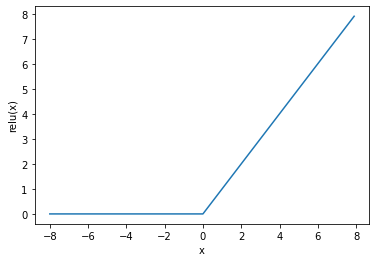

In [ ]:
x = Variable(torch.arange(-8.0,8.0,0.1,dtype=torch.float32).reshape(int(16/0.1),1), requires_grad=True)
y = torch.nn.functional.relu(x)
xyplot(x,y,'relu')

When the input is negative, the derivative of ReLU function is 0
and when the input is positive, the derivative of ReLU function is 1.
Note that the ReLU function is not differentiable
when the input takes value precisely equal to  0.
In these cases, we go with the left-hand-side (LHS) derivative
and say that the derivative is 0 when the input is 0.
We can get away with this because the input may never actually be zero.
There's an old adage that if subtle boundary conditions matter,
we are probably doing (*real*) mathematics, not engineering.
That conventional wisdom may apply here.
See the derivative of the ReLU function plotted below.

When we use .backward(), by default it is .backward(torch.Tensor([1])).This is useful when we are dealing with single scalar input.But here we are dealing with a vector input so we have to use this snippet.

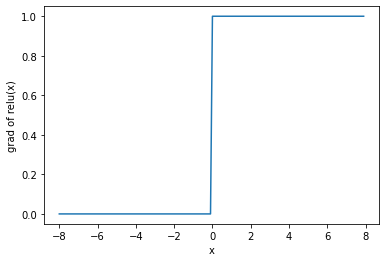

In [ ]:
y.backward(torch.ones_like(x), retain_graph=True)
xyplot(x,x.grad,"grad of relu")

Note that there are many variants to the ReLU function, such as the parameterized ReLU (pReLU) of [He et al., 2015](https://arxiv.org/abs/1502.01852). This variation adds a linear term to the ReLU, so some information still gets through, even when the argument is negative.

$$\mathrm{pReLU}(x) = \max(0, x) + \alpha \min(0, x)$$

The reason for using the ReLU is that its derivatives are particularly well behaved - either they vanish or they just let the argument through. This makes optimization better behaved and it reduces the issue of the vanishing gradient problem (more on this later).

## Sigmoid Function

The sigmoid function transforms its inputs which take values in $\mathbb{R}$ to the interval $(0,1)$.
For that reason, the sigmoid is often called a *squashing* function:
it squashes any input in the range (-inf, inf)
to some value in the range (0,1).

$$\mathrm{sigmoid}(x) = \frac{1}{1 + \exp(-x)}.$$

In the earliest neural networks, scientists
were interested in modeling biological neurons
which either *fire* or *don't fire*.
Thus the pioneers of this field, going all the way back to McCulloch and Pitts in the 1940s, were focused on thresholding units.
A thresholding function takes either value $0$
(if the input is below the threshold)
or value $1$ (if the input exceeds the threshold)


When attention shifted to gradient based learning,
the sigmoid function was a natural choice
because it is a smooth, differentiable approximation to a thresholding unit.
Sigmoids are still common as activation functions on the output units,
when we want to interpret the outputs as probabilities
for binary classification problems
(you can think of the sigmoid as a special case of the softmax)
but the sigmoid has mostly been replaced by the simpler and easier to train ReLU for most use in hidden layers.
In the "Recurrent Neural Network" chapter, we will describe
how sigmoid units can be used to control
the flow of information in a neural network
thanks to its capacity to transform the value range between 0 and 1.

See the sigmoid function plotted below.
When the input is close to 0, the sigmoid function
approaches a linear transformation.


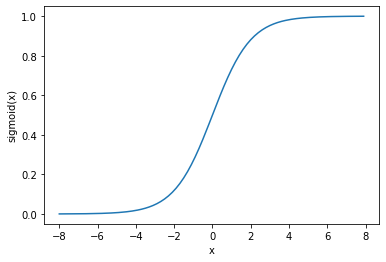

In [ ]:
x = Variable(torch.arange(-8.0,8.0,0.1, dtype=torch.float32).reshape(int(16/0.1),1), requires_grad=True)
y = torch.sigmoid(x)
xyplot(x,y,'sigmoid')

The derivative of sigmoid function is given by the following equation:

$$\frac{d}{dx} \mathrm{sigmoid}(x) = \frac{\exp(-x)}{(1 + \exp(-x))^2} = \mathrm{sigmoid}(x)\left(1-\mathrm{sigmoid}(x)\right).$$


The derivative of sigmoid function is plotted below.
Note that when the input is 0, the derivative of the sigmoid function
reaches a maximum of 0.25. As the input diverges from 0 in either direction, the derivative approaches 0.


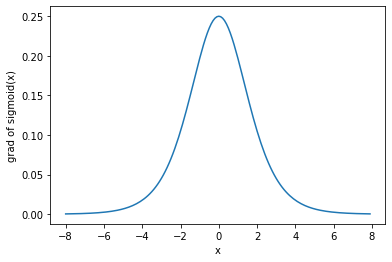

In [ ]:
y.backward(torch.ones_like(x), retain_graph=True)
xyplot(x,x.grad,'grad of sigmoid')

## Tanh Function

Like the sigmoid function, the tanh (Hyperbolic Tangent)
function also squashes its inputs,
transforms them into elements on the interval between -1 and 1:

$$\text{tanh}(x) = \frac{1 - \exp(-2x)}{1 + \exp(-2x)}.$$

We plot the tanh function blow. Note that as the input nears 0, the tanh function approaches a linear transformation. Although the shape of the function is similar to the sigmoid function, the tanh function exhibits point symmetry about the origin of the coordinate system.


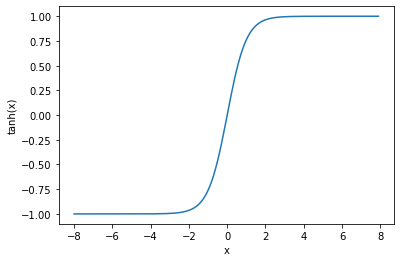

In [ ]:
x = Variable(torch.arange(-8.0,8.0,0.1, dtype=torch.float32).reshape(int(16/0.1),1), requires_grad=True)
y = torch.tanh(x)
xyplot(x,y,"tanh")

The derivative of the Tanh function is:

$$\frac{d}{dx} \mathrm{tanh}(x) = 1 - \mathrm{tanh}^2(x).$$

The derivative of tanh function is plotted below.
As the input nears 0,
the derivative of the tanh function approaches a maximum of 1.
And as we saw with the sigmoid function,
as the input moves away from 0 in either direction,
the derivative of the tanh function approaches 0.

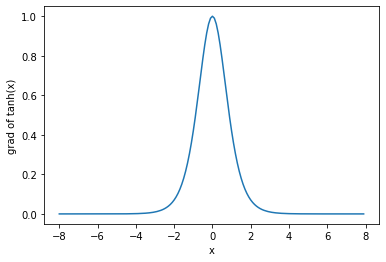

In [ ]:
y.backward(torch.ones_like(x), retain_graph=True)
xyplot(x,x.grad,"grad of tanh")

In summary, we now know how to incorporate nonlinearities
to build expressive multilayer neural network architectures.
As a side note, your knowledge now already
puts you in command of the state of the art in deep learning, circa 1990.
In fact, you have an advantage over anyone working the 1990s,
because you can leverage powerful open-source deep learning frameworks
to build models rapidly, using only a few lines of code.
Previously, getting these nets training
required researchers to code up thousands of lines of C and Fortran.



# Model Selection, Underfitting and Overfitting

## Model Selection

In machine learning, we usually select our final model
after evaluating several candidate models.
This process is called model selection.
Sometimes the models subject to comparison
are fundamentally different in nature
(say, decision trees vs linear models).
At other times, we are comparing
members of the same class of models
that have been trained with different hyperparameter settings.

With multilayer perceptrons for example,
we may wish to compare models with
different numbers of hidden layers,
different numbers of hidden units,
and various choices of the activation functions
applied to each hidden layer.
In order to determine the best among our candidate models,
we will typically employ a validation set.


### Validation Dataset

In principle we should not touch our test set
until after we have chosen all our hyper-parameters.
Were we to use the test data in the model selection process,
there is a risk that we might overfit the test data.
Then we would be in serious trouble.
If we overfit our training data,
there is always the evaluation on test data to keep us honest.
But if we overfit the test data, how would we ever know?


Thus, we should never rely on the test data for model selection.
And yet we cannot rely solely on the training data
for model selection either because
we cannot estimate the generalization error
on the very data that we use to train the model.

The common practice to address this problem
is to split our data three ways,
incorporating a *validation set*
in addition to the training and test sets.


In practical applications, the picture gets muddier.
While ideally we would only touch the test data once,
to assess the very best model or to compare
a small number of models to each other,
real-world test data is seldom discarded after just one use.
We can seldom afford a new test set for each round of experiments.

The result is a murky practice where the boundaries
between validation and test data are worryingly ambiguous.
Unless explicitly stated otherwise, in the experiments in this book
we are really working with what should rightly be called
training data and validation data, with no true test sets.
Therefore, the accuracy reported in each experiment
is really the validation accuracy and not a true test set accuracy.
The good news is that we do not need too much data in the validation set.
The uncertainty in our estimates can be shown
to be of the order of $\mathcal{O}(n^{-\frac{1}{2}})$.


### $K$-Fold Cross-Validation

When training data is scarce,
we might not even be able to afford to hold out
enough data to constitute a proper validation set.
One popular solution to this problem is to employ
$K$*-fold cross-validation*.
Here, the original training data is split into $K$ non-overlapping subsets.
Then model training and validation are executed $K$ times,
each time training on $K-1$ subsets and validating
on a different subset (the one not used for training in that round).
Finally, the training and validation error rates are estimated
by averaging over the results from the $K$ experiments.


**Exercise:** Implement a 5-fold validation scheme using the training data set from FashionMNIST. The function below should return the *average* accuracy over all 5 folds. Note: Use the same network, parameters, hyperparameters, and data from above.


In [ ]:
from sklearn.model_selection import KFold

def evaluate_accuracy(data_iter, net):
    acc_sum, n = 0.0, 0
    for X, y in data_iter:
        acc_sum += (net(X).argmax(dim=1) == y).sum().item()
        n += y.size()[0]  
    return acc_sum / n

def five_fold_validation(train_iter, test_iter):
  accuracy_fold = []
  avg_accuracy = 0.0
  K = 5   # number of folds
  ## Write your code here

  # getting mnist_train
  trans = transforms.ToTensor() 
  mnist_train = torchvision.datasets.FashionMNIST(root="./", train=True, transform=trans, target_transform=None, download=True)
  

  # splitting the mnist_train dataset to K=5 train/test_sets 

  kf = KFold(n_splits = K, shuffle = True)

  for fold, (train_index, test_index) in enumerate(kf.split(mnist_train)):
    mnist_train_fold = torch.utils.data.Subset(mnist_train, train_index)
    mnist_test_fold = torch.utils.data.Subset(mnist_train, test_index)
  
  # preparing batches of our new and setting hyperparameters
  
    lr, num_epochs, batch_size = 0.5, 10, 256
    
    if sys.platform.startswith('win'):
      num_workers = 0
    else:
      num_workers = 4

    train_iter_fold = DataLoader(mnist_train_fold, batch_size, shuffle=True, num_workers=num_workers)
    test_iter_fold = DataLoader(mnist_test_fold, batch_size, shuffle=False, num_workers=num_workers)
  
  # initalise model with my changed Net-Class and hyperparameters:
    net = Net(activator_function = nn.ReLU())
    net.apply(init_weights)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(net.parameters(), lr = lr)
  # train
    for epoch in range(num_epochs):
      net.train()
      for X, y in train_iter_fold:
        y_hat = net(X)
        l = criterion(y_hat, y)
        optimizer.zero_grad()
        l.backward()
        optimizer.step()
    
    # accuracy for #fold:
    accuracy_fold.append(evaluate_accuracy(test_iter_fold,net))

  avg_accuracy = sum(accuracy_fold)/len(accuracy_fold)
  ## end of function
  return avg_accuracy

five_fold_validation(train_iter, test_iter)

0.86745

## Underfitting or Overfitting?
When we compare the training and validation errors, we want to be mindful of two common situations: First, we want
to watch out for cases when our training error and validation error are both substantial but there is a little gap between
them. If the model is unable to reduce the training error, that could mean that our model is too simple (i.e., insufficiently
expressive) to capture the pattern that we are trying to model. Moreover, since the generalization gap between our training
and validation errors is small, we have reason to believe that we could get away with a more complex model. This
phenomenon is known as underfitting.

On the other hand, as we discussed above, we want to watch out for the cases when our training error is significantly lower
than our validation error, indicating severe overfitting. Note that overfitting is not always a bad thing. With deep learning
especially, it’s well known that the best predictive models often perform far better on training data than on holdout data.

Ultimately, we usually care more about the validation error than about the gap between the training and validation errors.
Whether we overfit or underfit can depend both on the complexity of our model and the size of the available training
datasets, two topics that we discuss below.

## Model Complexity 

To illustrate some classical intuition about overfitting and model complexity, we given an example using polynomials.
Given training data consisting of a single feature x and a corresponding real-valued label y, we try to find the polynomial
of degree d

$$y=\sum_{i=0}^d\ W^ix^i$$

to estimate the labels y. This is just a linear regression problem where our features are given by the powers of x, the wi
given the model’s weights, and the bias is given by w0 since x
0 = 1 for all x. Since this is just a linear regression problem,
we can use the squared error as our loss function.
A higher-order polynomial function is more complex than a lower order polynomial function, since the higher-order polynomial has more parameters and the model function’s selection range is wider. Fixing the training data set, higher-order
polynomial functions should always achieve lower (at worst, equal) training error relative to lower degree polynomials.
In fact, whenever the data points each have a distinct value of x, a polynomial function with degree equal to the number
of data points can fit the training set perfectly. We visualize the relationship between polynomial degree and under- vs
over-fitting below.

## Data Set Size

The other big consideration to bear in mind is the dataset size. Fixing our model, the fewer samples we have in the
training dataset, the more likely (and more severely) we are to encounter overfitting. As we increase the amount of
training data, the generalization error typically decreases. Moreover, in general, more data never hurts. For a fixed task
and data distribution, there is typically a relationship between model complexity and dataset size. Given more data, we
might profitably attempt to fit a more complex model. Absent sufficient data, simpler models may be difficult to beat. For
many tasks, deep learning only outperforms linear models when many thousands of training examples are available. In part, the current success of deep learning owes to the current abundance of massive datasets due to internet companies,
cheap storage, connected devices, and the broad digitization of the economy.

## Polynomial Regression
We can now explore these concepts interactively by fitting polynomials to data. To get started we’ll import our usual
packages.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as Data
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt

### Generating Data Sets

First we need data. Given x, we will use the following cubic polynomial to generate the labels on training and test data:

$$y=5+1.2x-3.4\frac{x^2}{2!}+5.6\frac{x^3}{3!}+ E where E-N(0,0.1)$$

The noise term ϵ obeys a normal distribution with a mean of 0 and a standard deviation of 0.1. We’ll synthesize 100
samples each for the training set and test set

In [ ]:
max_degree=20
n_train,n_test=100,100

In [ ]:
poly_features=torch.zeros(20,200)
true_w=torch.zeros(max_degree)
true_w[0:4] = torch.tensor([5, 1.2, -3.4, 5.6])
features = torch.randn(size=(n_train + n_test, 1))
x_list=torch.arange(max_degree)
x_list.float()
features=features.reshape(1,-1)

for i in range(1,max_degree):
    
    poly_features[i] = torch.pow(features,i)
    
print(features[:,4])
print(poly_features[:,4])

For optimization, we typically want to avoid very large values of gradients, losses, etc. This is why the monomials stored
in poly_features are rescaled from x

It allows us to avoid very large values for large exponents i. Factorials
are implemented in Gluon using the Gamma function, where n! = Γ(n + b 1).
Take a look at the first 2 samples from the generated data set. The value 1 is technically a feature, namely the constant
feature corresponding to the bias

In [ ]:
from scipy.special import factorial
ok=torch.arange(1,(max_degree) + 1).reshape((1, -1))

dr=factorial(ok)

dr2=torch.from_numpy(dr)

poly_features = poly_features.double() /dr2.t()

labels = torch.matmul(true_w.double(),poly_features)

poly_features = poly_features.type(torch.FloatTensor)

labels = labels.type(torch.FloatTensor)

labels += torch.randn(200)*0.5

### Defining, Training and Testing Model
We first define the plotting functionsemilogy, where the y axis makes use of the logarithmic scale

Since we will be attempting to fit the generated dataset using models of varying complexity, we insert the model definition
into the fit_and_plot function. The training and testing steps involved in polynomial function fitting are similar to
those previously described in softmax regression

In [ ]:
def semilogy(x_vals, y_vals, x_label, y_label, x2_vals=None, y2_vals=None, legend=None, figsize=(3.5, 2.5)):    
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.semilogy(x_vals, y_vals)
    if x2_vals and y2_vals:
        plt.semilogy(x2_vals, y2_vals, linestyle=':')
        plt.legend(legend)

In [ ]:
def fit_and_plot(train_features,train_labels,test_features,test_labels,no_inputs):
    class LinearRegressionModel(torch.nn.Module): 
        def __init__(self): 
            super(LinearRegressionModel, self).__init__() 
            self.linear = torch.nn.Linear(no_inputs, 1)  
  
        def forward(self, x): 
            y_pred = self.linear(x) 
            return y_pred 
    
    model = LinearRegressionModel() 
    criterion = torch.nn.MSELoss(reduction='sum') 
    optimizer = torch.optim.SGD(model.parameters(), lr = 0.01)
    train_ls,test_ls=[],[]   
    train_labels=train_labels.reshape(-1,1)
    train_ds=TensorDataset(train_features,train_labels)
    batch_size=10
    train_dl=DataLoader(train_ds,batch_size,shuffle=True)    
    test_labels=test_labels.reshape(-1,1)
    for ep in range(100):
        for xb,yb in train_dl:         
            pred_y = model(xb)     
            loss = criterion(pred_y, yb)             
            optimizer.zero_grad() 
            loss.backward() 
            optimizer.step()
          
        predytr=model(train_features)
        train_ls.append((criterion(predytr,train_labels)).mean())
        predyts=model(test_features)
        test_ls.append((criterion(predyts,test_labels)).mean())    
    
    print('final epoch:train loss',train_ls[-1],'test Loss',test_ls[-1])
    semilogy(range(1,ep+2), train_ls,'epoch','loss',range(1,ep+2),test_ls,['train','test'])

### Third-order Polynomial Function Fitting (Normal)

We will begin by first using a third-order polynomial function with the same order as the data generation function. The
results show that this model’s training error rate when using the testing data set is low. The trained model parameters are
also close to the true values w = [5, 1.2, −3.4, 5.6].


In [ ]:
poly_features_t=poly_features.t()
fit_and_plot(train_features=poly_features_t[:100,0:4],train_labels=labels[:100],test_features=poly_features_t[100:,0:4],test_labels=labels[100:],no_inputs=4)

### Linear Function Fitting
Let’s take another look at linear function fitting. After the decline in the early epoch, it becomes difficult to further
decrease this model’s training error rate. After the last epoch iteration has been completed, the training error rate is
still high. When used to fit non-linear patterns (like the third-order polynomial function here) linear models are liable to
underfit.

In [ ]:
fit_and_plot(train_features=poly_features_t[:100,0:3],train_labels=labels[:100],test_features=poly_features_t[100:,0:3],test_labels=labels[100:],no_inputs=3)

### Insufficient Training(Overfitting)
Now let’s try to train the model using a polynomial of too high degree. Here, there is insufficient data to learn that the
higher-degree coefficients should have values close to zero. As a result, our overly-complex model is far too susceptible
to being influenced by noise in the training data. Of course, our training error will now be low (even lower than if we had
the right model!) but our test error will be high.
Try out different model complexities (n_degree) and training set sizes (n_subset) to gain some intuition of what is
happening.


In [ ]:
fit_and_plot(train_features=poly_features_t[1:100,0:20],train_labels=labels[1:100],test_features=poly_features_t[100:,0:20],test_labels=labels[100:],no_inputs=20)